In [1]:
import os
os.environ["SSL_CERT_FILE"] = "/mnt/d/Travel Assistant/Musafir/Fortinet_CA_SSL(15).cer"
os.environ["REQUESTS_CA_BUNDLE"] = "/mnt/d/Travel Assistant/Musafir/Fortinet_CA_SSL(15).cer"

In [2]:
from qdrant_client import QdrantClient, models
import requests
from fastembed import TextEmbedding
import json
import random
import pandas as pd
from tqdm.auto import tqdm
import uuid

/mnt/d/Travel Assistant/Musafir/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sentence_transformers import SentenceTransformer

In [4]:
# import the data 
with open('../data/processed_data/documents-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)


In [5]:
# Ground Truth data
df_gt = pd.read_csv('../data/result/groud-truth-retrieval.csv')

In [6]:
ground_truth =  df_gt.to_dict(orient="records")

In [7]:
ground_truth[10]

{'id': '91c82200',
 'city': 'Cairo',
 'question': 'What was the purpose of Abdeen Palace in Cairo until 1952?'}

In [8]:
doc_idx = {d['id']: d for d in documents}
doc_idx['91c82200']['text']


'30.0417 31.2483 4 Abdeen Palace . About 1 km east of Midan El-Tahrir, it was the royal residence until the Egyptian monarchy was deposed in 1952. ( updated Jan 2018 )'

In [9]:
model_name = 'multi-qa-distilbert-cos-v1'
model = SentenceTransformer(model_name)

In [10]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False, 'architecture': 'DistilBertModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [11]:
#connecting to local Qdrant instance
qdrant_client = QdrantClient(url="http://localhost:6333")

/tmp/ipykernel_8543/2923977033.py:2: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.12.4. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant_client = QdrantClient(url="http://localhost:6333")


In [12]:
def rrf_search(query: str, limit: int = 5) -> list[models.ScoredPoint]:
    results = qdrant_client.query_points(
        collection_name="traveller-dense-and-sparse",
        prefetch=[
            models.Prefetch(
                query=models.Document(
                    text=query,
                    model="jinaai/jina-embeddings-v2-small-en",
                ),
                using="jina-small",
                limit=(5 * limit),
            ),
            models.Prefetch(
                query=models.Document(
                    text=query,
                    model="Qdrant/bm25",
                ),
                using="bm25",
                limit=(1 * limit),
            ),
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
        with_payload=True,
    )

    return results.points

In [13]:
from mistralai import Mistral
from mistralai.models import UserMessage
import os
from dotenv import load_dotenv


In [14]:
# loads variables from .env
load_dotenv()  

True

In [15]:
api_key = os.getenv("API_KEY")

In [16]:
llm_client = Mistral(api_key = api_key)

In [17]:
def build_prompt(query, search_results):
    context_template = "Q: {question}\n A: {text}"

    context_parts = []
    for point in search_results: 
        payload = point.payload
        context_parts.append(
            context_template.format(
                question=query,
                text=payload.get("text", "")
            )
        )

    context = "\n\n".join(context_parts)
    
    prompt_template = """
You're a travel assistant. Answer the QUESTION based on the CONTEXT from the traveller database.
Use only the facts from the CONTEXT when answering the QUESTION. If the QUESTION doesn't have a CONTEXT in the data just mention
you cannot answer the question.

QUESTION: {question}

CONTEXT:
{context}

    """.strip()
    
    prompt = prompt_template.format(question=query, context=context)
    return prompt


In [78]:
def llm(prompt):
    response = llm_client.chat.complete(
        model= "mistral-medium-2508",
        messages=[UserMessage(content=prompt)],
    )

    return response.choices[0].message.content

In [19]:
def rag(query: dict):
    if isinstance(query, dict):
        query = query.get("question", "")
    elif not isinstance(query, str):
        raise ValueError("Query must be a string or a dictionary with a 'question' key.")
        
    search_results = rrf_search(query=query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer


In [80]:
answer_llm = rag(ground_truth[10])
print(answer_llm)

Abdeen Palace in Cairo served as the **royal residence** until the Egyptian monarchy was deposed in **1952**.


In [81]:
answer_org = doc_idx['91c82200']['text']
print(answer_org)

30.0417 31.2483 4 Abdeen Palace . About 1 km east of Midan El-Tahrir, it was the royal residence until the Egyptian monarchy was deposed in 1952. ( updated Jan 2018 )


# Cosine similarity metric

## Using mistral-medium-2508
Premier model

In [82]:
v_llm = model.encode(answer_llm)
v_org = model.encode(answer_org)

v_llm.dot(v_org)

0.8076176

In [23]:
answers = {}


In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['id']
    original_doc = doc_idx[doc_id]
    answer_org = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_org': answer_org,
        'document': doc_id,
        'question': rec['question'],
        'city': rec['city'],
    }
    

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2685/2715 [00:49<00:01, 17.14it/s]

In [ ]:
len(answers)

In [ ]:
results_mistral_medium = [None] * len(ground_truth)

for i, val in answers.items():
    results_mistral_medium[i] = val.copy()
    results_mistral_medium[i].update(ground_truth[i])

In [30]:
import pandas as pd

In [32]:
df_mistral_medium = pd.DataFrame(results_mistral_medium)

In [66]:
RESULT_FOLDER = "../data/result"
os.makedirs(RESULT_FOLDER, exist_ok=True)

In [ ]:
df_mistral_medium.to_csv(f"{RESULT_FOLDER}/results-mistral_medium.csv", index=False)


In [40]:
medium_df.head()

,answer_llm,answer_org,document,question,city,id
0,The name of the oldest known pyramid in Dahshu...,29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the name of the oldest known pyramid i...,Cairo,f7845786
1,The **Red Pyramid** in Dahshur has an entrance...,29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,Which pyramid in Dahshur has an entrance to th...,Cairo,f7845786
2,"Based on the provided **CONTEXT**, the distinc...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the distinctive feature of the Bent Py...,Cairo,f7845786
3,"Based on the provided **CONTEXT**, the followi...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,How many pyramids are mentioned to be in the D...,Cairo,f7845786
4,"Based on the **CONTEXT**, the atmosphere aroun...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the atmosphere around Dahshur Pyramids...,Cairo,f7845786


In [41]:
medium_df = pd.read_csv(f"{RESULT_FOLDER}/results-mistral_medium.csv")

## mistral-small-2506
Open model

In [18]:
def llm(prompt):
    response = llm_client.chat.complete(
        model="open-mixtral-8x7b",
        messages=[UserMessage(content=prompt)],
    )


    return response.choices[0].message.content

In [20]:
answer_llm = rag(ground_truth[10])
print(answer_llm)

The purpose of Abdeen Palace in Cairo until 1952 was as the royal residence.


In [21]:
answer_org = doc_idx['91c82200']['text']
print(answer_org)

30.0417 31.2483 4 Abdeen Palace . About 1 km east of Midan El-Tahrir, it was the royal residence until the Egyptian monarchy was deposed in 1952. ( updated Jan 2018 )


In [22]:
v_llm = model.encode(answer_llm)
v_org = model.encode(answer_org)

v_llm.dot(v_org)

0.71375585

In [30]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [31]:
def process_record(rec):
    model = "open-mixtral-8x7b"
    answer_llm = rag(rec)
    
    doc_id = rec['id']
    original_doc = doc_idx[doc_id]
    answer_org = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_org': answer_org,
        'document': doc_id,
        'question': rec['question'],
        'city': rec['city'],
    }



In [34]:
# result_mistral_big = map_progress(pool, ground_truth, process_record)


In [36]:
answers_big = {}


In [57]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers_big:
        continue

    answer_llm = rag(rec)
    doc_id = rec['id']
    original_doc = doc_idx[doc_id]
    answer_org = original_doc['text']

    answers_big[i] = {
        'answer_llm': answer_llm,
        'answer_org': answer_org,
        'document': doc_id,
        'question': rec['question'],
        'city': rec['city'],
    }
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2715/2715 [00:51<00:00, 53.11it/s]


In [62]:
results_mistral_big = [None] * len(ground_truth)

for i, val in answers_big.items():
    results_mistral_big[i] = val.copy()
    results_mistral_big[i].update(ground_truth[i])

In [64]:
df_mistral_big = pd.DataFrame(results_mistral_big)

In [67]:
df_mistral_big.to_csv(f"{RESULT_FOLDER}/results-mistral_big.csv", index=False)


In [69]:
!head f"{RESULT_FOLDER}/results-mistral_big.csv"

head: cannot open 'f../data/result/results-mistral_big.csv' for reading: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Code for Evalutaion 

# Cosine smiliartity 

In [45]:
results_medium = medium_df.to_dict(orient="records")

In [47]:
record = results_medium[2000]

In [51]:
def compute_similarity(record):

    answer_llm = record["answer_llm"]
    answer_org = record["answer_org"]
    v_llm = model.encode(answer_llm)
    v_org = model.encode(answer_org)
    
    return v_llm.dot(v_org)

In [53]:
similarity = []

for record in tqdm(results_medium):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2715/2715 [04:11<00:00, 10.81it/s]


In [54]:
medium_df['cosine'] = similarity

In [55]:
medium_df

,answer_llm,answer_org,document,question,city,id,cosine
0,The name of the oldest known pyramid in Dahshu...,29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the name of the oldest known pyramid i...,Cairo,f7845786,0.744416
1,The **Red Pyramid** in Dahshur has an entrance...,29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,Which pyramid in Dahshur has an entrance to th...,Cairo,f7845786,0.649594
2,"Based on the provided **CONTEXT**, the distinc...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the distinctive feature of the Bent Py...,Cairo,f7845786,0.465671
3,"Based on the provided **CONTEXT**, the followi...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,How many pyramids are mentioned to be in the D...,Cairo,f7845786,0.695287
4,"Based on the **CONTEXT**, the atmosphere aroun...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the atmosphere around Dahshur Pyramids...,Cairo,f7845786,0.734467
...,...,...,...,...,...,...,...
2710,"Based on the provided **CONTEXT**, here is the...","₩15,000–35,000",feb11863,What is the estimated price range for dining o...,Seoul,feb11863,0.492113
2711,"Based on the **CONTEXT**, you **will not** nee...","₩15,000–35,000",feb11863,"Will I need more than ₩35,000 for a meal in Se...",Seoul,feb11863,0.547441
2712,"Yes, you can easily find a meal for under ₩15,...","₩15,000–35,000",feb11863,"Can I find a meal for under ₩15,000 in Seoul?",Seoul,feb11863,0.481077
2713,"Based on the **CONTEXT**, the **lowest amount ...","₩15,000–35,000",feb11863,What is the lowest amount I can expect to spen...,Seoul,feb11863,0.494290


In [56]:
medium_df.iloc[2000].to_dict()

{'answer_llm': 'The Vatican is located in the **Vatican** area of Rome. It is described as the **Papal City State** and its surrounding Italian neighborhood.',
 'answer_org': 'Modern Centre Old Rome Vatican Colosseo North Centre Trastevere',
 'document': '913cf7c3',
 'question': 'Which part of Rome is the Vatican located in?',
 'city': 'Rome',
 'id': '913cf7c3',
 'cosine': 0.5046500563621521}

In [57]:
medium_df['cosine'].describe()

count    2715.000000
mean        0.674111
std         0.176574
min        -0.063424
25%         0.609269
50%         0.707447
75%         0.788128
max         1.000000
Name: cosine, dtype: float64

## Add rouge 

In [92]:
from rouge import Rouge
import numpy as np

In [87]:
rouge_score = Rouge()

In [88]:
r = medium_df.iloc[2000]
scores = rouge_score.get_scores(r.answer_llm, r.answer_org)

In [89]:
scores

[{'rouge-1': {'r': 0.25, 'p': 0.09523809523809523, 'f': 0.13793103048751498},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.125,
   'p': 0.047619047619047616,
   'f': 0.06896551324613578}}]

In [95]:
rouge_sim = []

for r in tqdm(results_medium):
    scores = rouge_score.get_scores(r['answer_llm'], r['answer_org'])
    rouge_sim.append(scores[0]['rouge-1']['f'])
    
avg_rouge_smiliarity=np.mean(rouge_sim)
print(f"The average Rouge-1 F1 for the whole DF: ",avg_rouge_smiliarity.round(2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2715/2715 [00:05<00:00, 538.18it/s]

The average Rouge-1 F1 for the whole DF:  0.24


In [96]:
rouge_sim = []

for r in tqdm(results_medium):
    scores = rouge_score.get_scores(r['answer_llm'], r['answer_org'])
    rouge_sim.append(scores[0]['rouge-l']['f'])
    
avg_rouge_smiliarity=np.mean(rouge_sim)
print(f"The average rouge-l F1 for the whole DF: ",avg_rouge_smiliarity.round(2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2715/2715 [00:04<00:00, 545.88it/s]

The average Rouge-1 F1 for the whole DF:  0.22


In [63]:
import seaborn as sns

In [64]:
# sns.distplot(df_gpt4o['cosine'], label='4o')
# sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

# plt.title("RAG LLM performance")
# plt.xlabel("A->Q->A' Cosine Similarity")
# plt.legend()

/tmp/ipykernel_3007/829340080.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(medium_df['cosine'], label='medium')


<Axes: xlabel='cosine', ylabel='Density'>

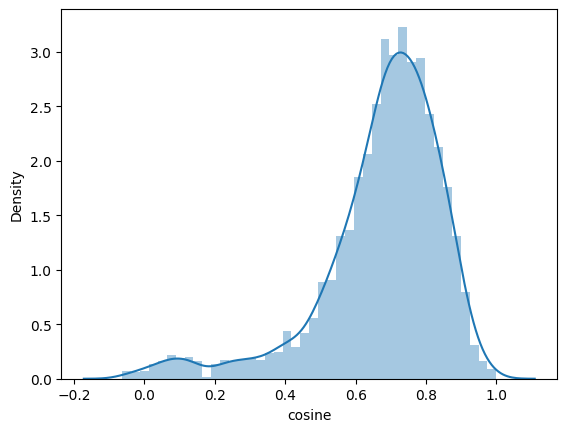

In [65]:
sns.distplot(medium_df['cosine'], label='medium')

In [66]:
## Try the code for other models 

# LLM as a judge

In [132]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_org}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [133]:
medium_df

,answer_llm,answer_org,document,question,city,id,cosine
0,The name of the oldest known pyramid in Dahshu...,29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the name of the oldest known pyramid i...,Cairo,f7845786,0.744416
1,The **Red Pyramid** in Dahshur has an entrance...,29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,Which pyramid in Dahshur has an entrance to th...,Cairo,f7845786,0.649594
2,"Based on the provided **CONTEXT**, the distinc...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the distinctive feature of the Bent Py...,Cairo,f7845786,0.465671
3,"Based on the provided **CONTEXT**, the followi...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,How many pyramids are mentioned to be in the D...,Cairo,f7845786,0.695287
4,"Based on the **CONTEXT**, the atmosphere aroun...",29.8 31.233333 1 Dahshur Pyramids . For a cont...,f7845786,What is the atmosphere around Dahshur Pyramids...,Cairo,f7845786,0.734467
...,...,...,...,...,...,...,...
2710,"Based on the provided **CONTEXT**, here is the...","₩15,000–35,000",feb11863,What is the estimated price range for dining o...,Seoul,feb11863,0.492113
2711,"Based on the **CONTEXT**, you **will not** nee...","₩15,000–35,000",feb11863,"Will I need more than ₩35,000 for a meal in Se...",Seoul,feb11863,0.547441
2712,"Yes, you can easily find a meal for under ₩15,...","₩15,000–35,000",feb11863,"Can I find a meal for under ₩15,000 in Seoul?",Seoul,feb11863,0.481077
2713,"Based on the **CONTEXT**, the **lowest amount ...","₩15,000–35,000",feb11863,What is the lowest amount I can expect to spen...,Seoul,feb11863,0.494290


In [134]:
record = results_medium[2000]

In [135]:
prompt  = prompt1_template.format(**record)
print(prompt)
 

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Modern Centre Old Rome Vatican Colosseo North Centre Trastevere
Generated Question: Which part of Rome is the Vatican located in?
Generated Answer: The Vatican is located in the **Vatican** area of Rome. It is described as the **Papal City State** and its surrounding Italian neighborhood.

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


## Define the model that has the best perfromance to parce that one

In [141]:
def llm(prompt):
    response = llm_client.chat.complete(
        model="open-mixtral-8x7b",
        messages=[UserMessage(content=prompt)],
    )


    return response.choices[0].message.content

In [142]:
answer = llm(prompt)
answer

'{\n  "Relevance": "PARTLY_RELEVANT",\n  "Explanation": "The generated answer correctly identifies the location of the Vatican in Rome, but it does not match the exact phrasing or provide the same level of detail as the original answer. The generated answer refers to the Vatican as a \'city-state\' and mentions its \'Italian neighborhood\', while the original answer simply refers to it as \'Vatican\'. However, the key point of the answer is still relevant to the original answer."\n}'

In [143]:
import json

In [144]:
json.loads(answer)

{'Relevance': 'PARTLY_RELEVANT',
 'Explanation': "The generated answer correctly identifies the location of the Vatican in Rome, but it does not match the exact phrasing or provide the same level of detail as the original answer. The generated answer refers to the Vatican as a 'city-state' and mentions its 'Italian neighborhood', while the original answer simply refers to it as 'Vatican'. However, the key point of the answer is still relevant to the original answer."}

In [191]:
evaluations = []


In [202]:
for record in tqdm(results_medium):
    
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt)
    evaluations.append(evaluation)

 10%|██████████████▏                                                                                                                           | 278/2715 [06:00<52:35,  1.30s/it]


SDKError: API error occurred: Status 429
{"object":"error","message":"Rate limit exceeded","type":"rate_limited","param":null,"code":"1300"}

In [201]:
len(evaluations)

543

In [185]:
# json_evaluations = []

# for i, str_eval in enumerate(evaluations):
#     json_eval = json.loads(str_eval)
#     json_evaluations.append(json_eval)

In [187]:
parsed_evaluations = []

for e in evaluations:

    eval_json = json.loads(e["evaluation"])
    parsed_evaluations.append({
        "index": e["index"],
        "record_id": e["record_id"],
        "Relevance": eval_json.get("Relevance"),
        "Explanation": eval_json.get("Explanation")
    })


parsed_evaluations[:2]  

[{'index': 0,
  'record_id': 'f7845786',
  'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer correctly identifies the name of the oldest known pyramid in Dahshur as the Red Pyramid, which is consistent with the information provided in the original answer.'},
 {'index': 5,
  'record_id': 'fca551b1',
  'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer directly provides the coordinates of Al-Azhar Park, which is the same information as the original answer.'}]

In [189]:
len(parsed_evaluations)

543

In [181]:
df_evaluations = pd.DataFrame(evaluations)

In [183]:
df_evaluations

,index,record_id,evaluation
0,0,f7845786,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
1,5,fca551b1,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
2,10,91c82200,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
3,15,a4b7a503,"{\n ""Relevance"": ""PARTLY_RELEVANT"",\n ""Expla..."
4,20,84d1da2a,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
...,...,...,...
538,2690,86841f08,"{\n ""Relevance"": ""RELEVANT"",\n ""Explanation""..."
539,2695,6f81da78,"{\n ""Relevance"": ""PARTLY_RELEVANT"",\n ""Expla..."
540,2700,2bb90712,"{\n ""Relevance"": ""PARTLY_RELEVANT"",\n ""Expla..."
541,2705,7a40c5e2,"{\n ""Relevance"": ""PARTLY_RELEVANT"",\n ""Expla..."


In [182]:
df_evaluations.Relevance.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Relevance'

## Second prompt 

In [ ]:
evaluations_2 = []


In [ ]:
for i, record in enumerate(tqdm(results_medium)):
    if i in evaluations:
        continue
        
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt)
    evaluations_2.append(evaluation)

In [ ]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [ ]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [ ]:
df_evaluations_2.Relevance.value_counts()

# Saving all the data

In [ ]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)